# **Homework 8 - Anomaly Detection**

If there are any questions, please contact ntu-ml-2021spring-ta@googlegroups.com

# Mounting your gdrive (Optional)
By mounting your gdrive, you can save and manage your data and models in your Google drive

In [1]:
!nvidia-smi

Wed May 19 13:35:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# your workspace in your drive
#workspace = 'Research Courses/Y4S2/ML - 李宏毅/HW8'
workspace = 'HW8'

#try:
os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))
#except:
#  os.mkdir(os.path.join('/content/gdrive/My Drive/', workspace))
#  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))

In [4]:
!ls

 best_classif.pt   'New Microsoft Word Document.docx'
 best_cnnae.pt	    PREDICTION_FILE.csv
 data-bin	   '~$w Microsoft Word Document.docx'
 HW08-clean.ipynb


# Set up the environment


## Package installation

In [5]:
# Training progress bar
#!pip install -q qqdm

## Downloading data
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/15XWO-zI-AKW0igfwSydmwSGa8ENb9wCg

In [6]:

#!gdown --id '15XWO-zI-AKW0igfwSydmwSGa8ENb9wCg' --output data-bin.tar.gz 

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id '167SejKP7vLB2sbHfQHJii8-WisYoTmLH' --output data-bin.tar.gz 

# 1
# !gdown --id '1BXJaeouaf4Zml2aeNlQfJ_AOcItTWcef' --output data-bin.tar.gz 

# 2
# !gdown --id '1HkBPxhk-9rD0H_cen2YjLXxsvInkToBl' --output data-bin.tar.gz 

# 3
# !gdown --id '1K_WGT8AD8iMsOSMYtK1Gp6vyEcRNCLQM' --output data-bin.tar.gz 

# 4
# !gdown --id '1LGdyDUQA4EPaWTEUVm_upPAEl6qAh91Z' --output data-bin.tar.gz 

# 5
# !gdown --id '1N9wNazaMy4A0UQ6pow5DXfVJ6abaiQxU' --output data-bin.tar.gz 

# 6
# !gdown --id '1PC66MrDw-tnuYN2STauPg2FoJYm3_Yy5' --output data-bin.tar.gz 

# 7
# !gdown --id '1mzy4E06CcBJc0udhPgL4zMhDlWibKbVs' --output data-bin.tar.gz 

# 8
# !gdown --id '1zPbCF7whPv1Xs_2azwe1SUweomgLsVwH' --output data-bin.tar.gz 

# 9
#!gdown --id '1Uc1Y8YYAwj7D0_wd0MeSX3szUiIB1rLU' --output data-bin.tar.gz 

## Untar data

data-bin contains 2 files
```
data-bin/
├── trainingset.npy
├── testingset.npy
...
```

In [7]:
"""
!tar zxvf data-bin.tar.gz
!ls data-bin
!ls data-bin
!rm data-bin.tar.gz
"""

'\n!tar zxvf data-bin.tar.gz\n!ls data-bin\n!ls data-bin\n!rm data-bin.tar.gz\n'

# Import packages

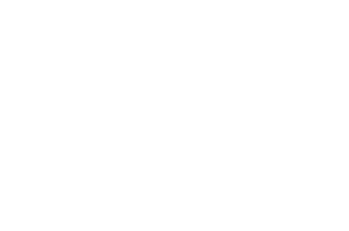

In [8]:
import numpy as np
import random
import torch

from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq, kmeans

#from qqdm import qqdm, format_str
import pandas as pd

import pdb  # use pdb.set_trace() to set breakpoints for debugging

import torchvision
import matplotlib.pyplot as plt
plt.axis('off')

#from torch.distributions import uniform
from torch.distributions import normal


# Loading data

In [9]:

train = np.load('data-bin/trainingset.npy', allow_pickle=True)
test = np.load('data-bin/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(140001, 64, 64, 3)
(19999, 64, 64, 3)


In [10]:
#plt.figure(figsize=(5,5))
#plt.imshow(train[10])

## Random seed
Set the random seed to a certain value for reproducibility.

In [11]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(19530615)

# Autoencoder

# Models & loss

Lecture video：https://www.youtube.com/watch?v=6W8FqUGYyDo&list=PLJV_el3uVTsOK_ZK5L0Iv_EQoL1JefRL4&index=8

fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner

conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/

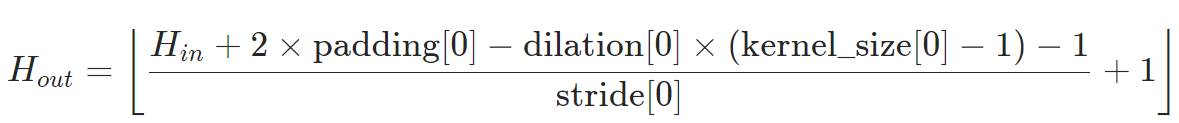

In [20]:
#{'cnn', 'fcn', 'vae', 'resnet'}

class conv_classifier(nn.Module):
    def __init__(self):
        super(conv_classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 64, 64]
        # u can treat nn.Sequential as a list

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),   #[12, 32, 32] 
            nn.BatchNorm2d(12),      
            nn.ReLU(),
            #nn.MaxPool2d(2, 2, 0),                      #[12, 16, 16] 
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  #[24, 8, 8] 
            nn.BatchNorm2d(24),        
            nn.ReLU(),
            #nn.MaxPool2d(2, 2, 0),                      #[24, 4, 4] 
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),  #[48, 2, 2] 
            nn.BatchNorm2d(48), 
            nn.ReLU(),
            nn.Conv2d(48, 48, 4, stride=2, padding=1),  #[48, 2, 2] 
            nn.BatchNorm2d(48), 
            nn.ReLU(),
            nn.Conv2d(48, 48, 4, stride=2, padding=1),  #[48, 2, 2] 
            nn.BatchNorm2d(48), 
            nn.ReLU(),
        )

        self.cnn = nn.Sequential(
            nn.Conv2d(64, 8, 4, stride=2, padding=1),   # height/4 
            nn.BatchNorm2d(8),      
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),   
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(48 * 2 * 2, 1),
            #nn.ReLU(),
            nn.Sigmoid(), #only for binary
        )

        #resnet = models.resnet18(pretrained=False)
        #modules = list(resnet.children())[:5]      #output = [64, 16, 16]
        #self.resnet = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder_cnn(x)
        #x = self.resnet(x)    #[64, 16, 16]
        #x = self.cnn(x)       #[8, 4, 4]
        x = x.flatten(1)
        x = self.fc_layers(x)
        return x.flatten()

# maybe it can be smaller
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),   
            nn.BatchNorm2d(12),      
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),        
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48), 
            nn.ReLU(),
            #nn.Conv2d(48, 96, 4, stride=2, padding=1),   # medium: remove this layer
            #nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), # medium: remove this layer
            #nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.BatchNorm2d(24),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )

    def forward(self, x, mode='ae'):

        #if mode not in ['encoder', 'decoder']:
        #  mode = 'ae'

        if mode in ['encoder','ae']:
          x = self.encoder(x)
        if mode in ['decoder','ae']:
          x = self.decoder(x)

        return x


# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [21]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
                            transforms.Lambda(lambda x: x.to(torch.float32)),
                            transforms.Lambda(lambda x: 2. * x/255. - 1.),
                            transforms.RandomHorizontalFlip(),
                            #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Initialize
- hyperparameters
- dataloader
- model
- optimizer & loss


In [22]:
## Training hyperparameters
num_epochs = 100
batch_size = 128 #10000 # medium: smaller batchsize
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'cnn' #'resnet'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
#model_classes = {'resnet': Resnet(), 'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), }
model_classes = {'cnn':conv_autoencoder()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

classifier = conv_classifier().cuda() #torchvision.models.resnet18(pretrained=False).cuda()#.to(device)
bce_criterion = nn.BCELoss()
#bce_criterion = nn.BCELoss()
classif_optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate,
                            momentum=0.9, weight_decay=0.0001, nesterov=True)


In [23]:
"""
img = next(iter(train_dataloader))
images = [(img[i]+1)/2 for i in range(30)]

grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(30,20))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
"""

'\nimg = next(iter(train_dataloader))\nimages = [(img[i]+1)/2 for i in range(30)]\n\ngrid_img = torchvision.utils.make_grid(images, nrow=10)\nplt.figure(figsize=(30,20))\nplt.imshow(grid_img.permute(1, 2, 0))\nplt.show()\n'

In [24]:
print('Num Params = ', sum(p.numel() for p in model.parameters() if p.requires_grad)) 
#print(model)

Num Params =  47601


In [25]:
print('Num Params = ', sum(p.numel() for p in classifier.parameters() if p.requires_grad)) 
#print(classifier)

Num Params =  106293


## Training loop

In [26]:
def display_img(x, title, num = 10):

  images = x.cpu()
  plt.figure(figsize=(30,8))

  for i in range(num):

    ax = plt.subplot(1, num, i + 1)
    ax.axis('off') # turn axis off for each subplot
    inp = ((images[i]+1)/2).numpy()
    inp = inp.transpose((1, 2, 0))
    plt.imshow(inp)

    if title != None:
      plt.title('{:>5.2f}%'.format(title[i].item()*100))
  
  plt.show()

  #grid_img = torchvision.utils.make_grid(images, nrow=num)
  #plt.imshow(grid_img.permute(1, 2, 0))
  #plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


====== [Ep  1/100] :   cnnae_loss = 0.03417     classif_loss =     nan =============================================
====== [Ep  2/100] :   cnnae_loss = 0.01111     classif_loss =     nan =============================================
====== [Ep  3/100] :   cnnae_loss = 0.00790     classif_loss =     nan =============================================
====== [Ep  4/100] :   cnnae_loss = 0.00672     classif_loss =     nan =============================================
====== [Ep  5/100] :   cnnae_loss = 0.00599     classif_loss = 0.04862 =============================================


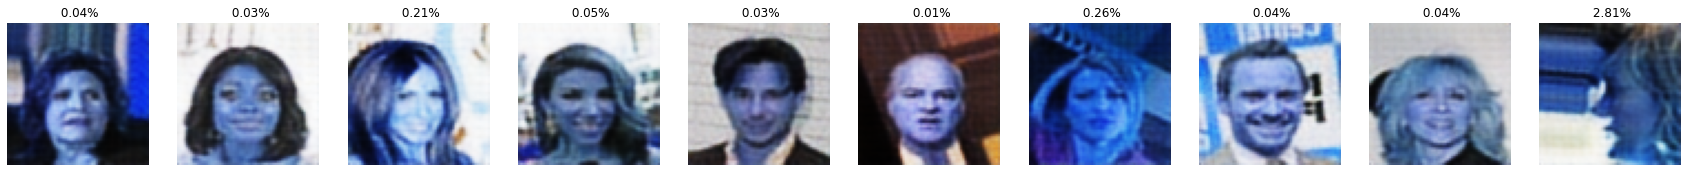

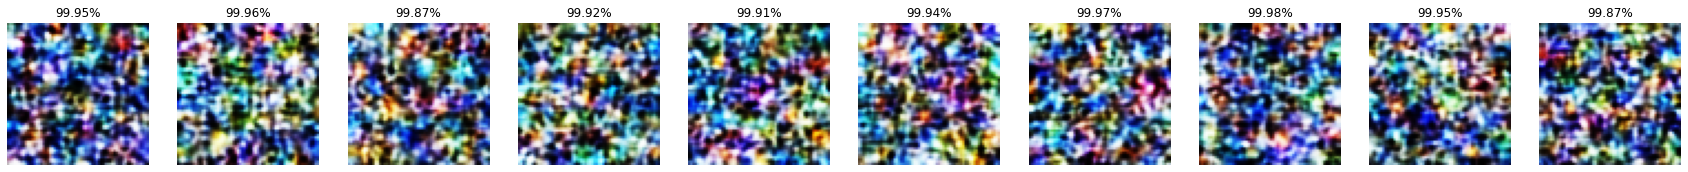

======================== [ Saved BEST ] ========================
====== [Ep  6/100] :   cnnae_loss = 0.00552     classif_loss =     nan =============================================
====== [Ep  7/100] :   cnnae_loss = 0.00512     classif_loss =     nan =============================================
====== [Ep  8/100] :   cnnae_loss = 0.00474     classif_loss =     nan =============================================
====== [Ep  9/100] :   cnnae_loss = 0.00445     classif_loss =     nan =============================================
====== [Ep 10/100] :   cnnae_loss = 0.00420     classif_loss = 0.00233 =============================================


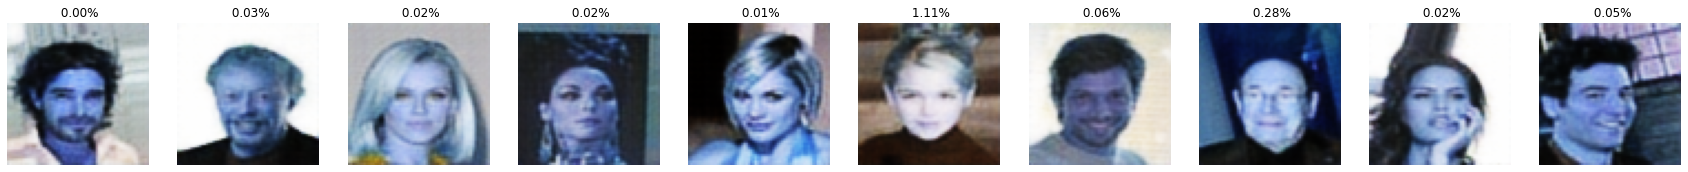

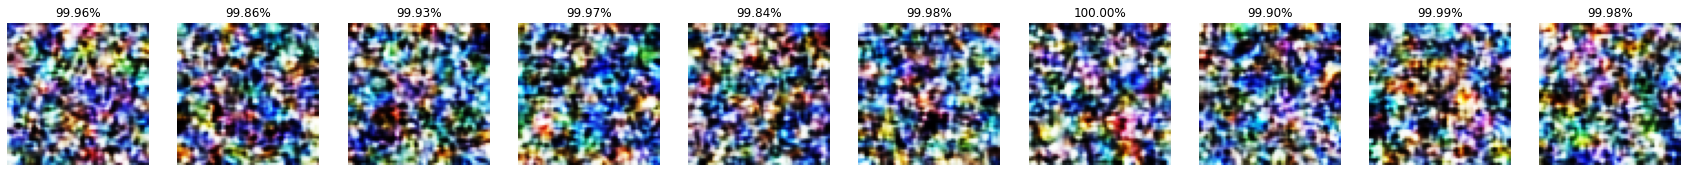

======================== [ Saved BEST ] ========================
====== [Ep 11/100] :   cnnae_loss = 0.00404     classif_loss =     nan =============================================
====== [Ep 12/100] :   cnnae_loss = 0.00395     classif_loss =     nan =============================================
====== [Ep 13/100] :   cnnae_loss = 0.00382     classif_loss =     nan =============================================
====== [Ep 14/100] :   cnnae_loss = 0.00374     classif_loss =     nan =============================================
====== [Ep 15/100] :   cnnae_loss = 0.00365     classif_loss = 0.00125 =============================================


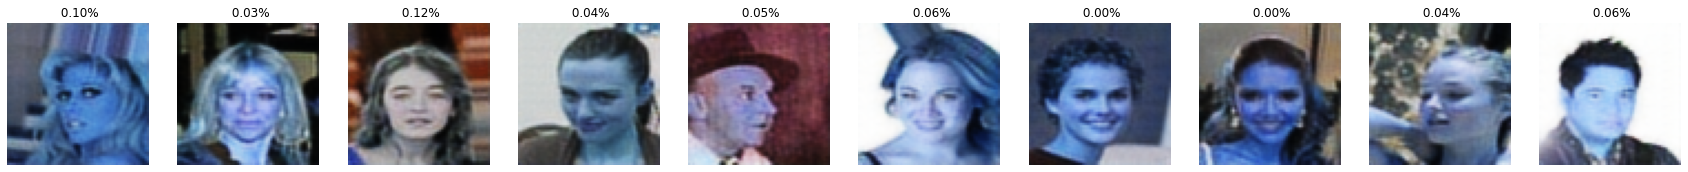

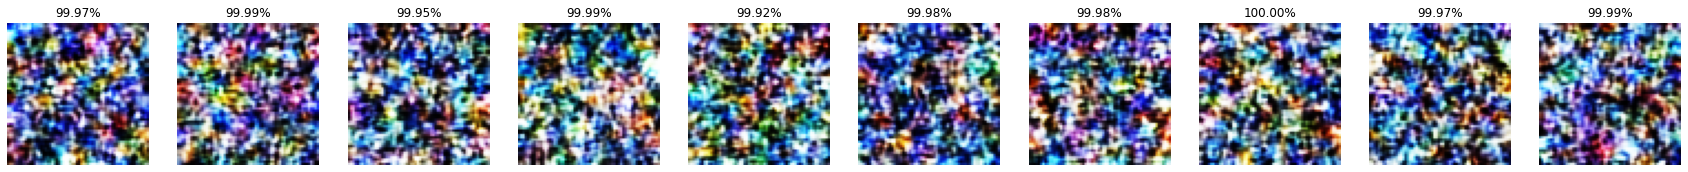

======================== [ Saved BEST ] ========================
====== [Ep 16/100] :   cnnae_loss = 0.00358     classif_loss =     nan =============================================
====== [Ep 17/100] :   cnnae_loss = 0.00352     classif_loss =     nan =============================================
====== [Ep 18/100] :   cnnae_loss = 0.00347     classif_loss =     nan =============================================
====== [Ep 19/100] :   cnnae_loss = 0.00341     classif_loss =     nan =============================================
====== [Ep 20/100] :   cnnae_loss = 0.00333     classif_loss = 0.00083 =============================================


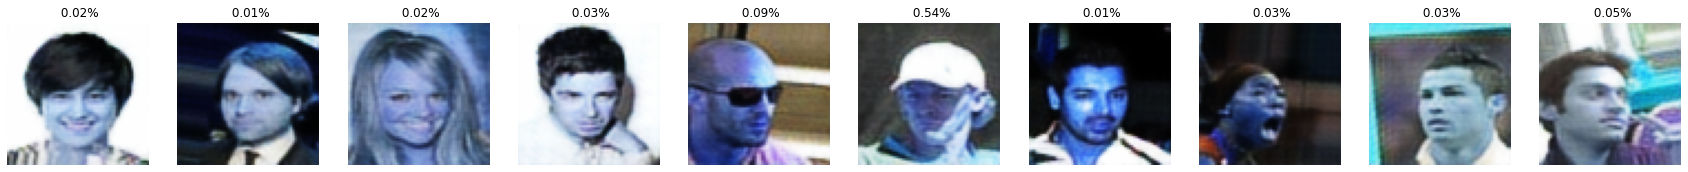

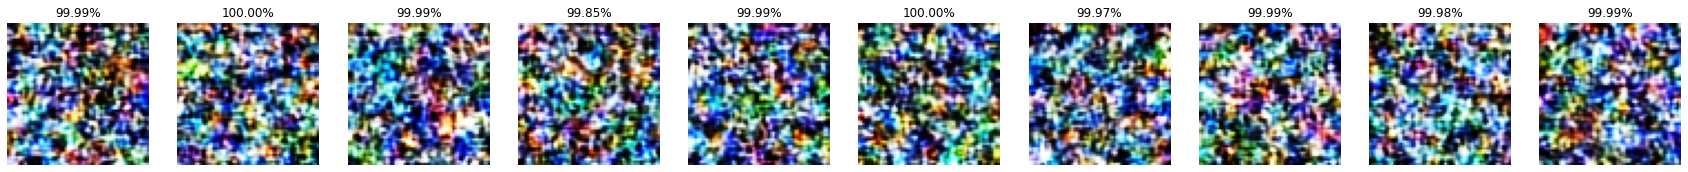

======================== [ Saved BEST ] ========================
====== [Ep 21/100] :   cnnae_loss = 0.00331     classif_loss =     nan =============================================
====== [Ep 22/100] :   cnnae_loss = 0.00325     classif_loss =     nan =============================================
====== [Ep 23/100] :   cnnae_loss = 0.00323     classif_loss =     nan =============================================
====== [Ep 24/100] :   cnnae_loss = 0.00316     classif_loss =     nan =============================================
====== [Ep 25/100] :   cnnae_loss = 0.00313     classif_loss = 0.00064 =============================================


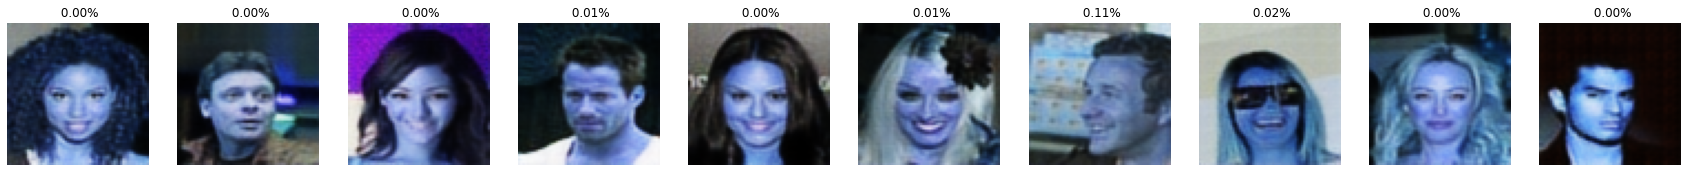

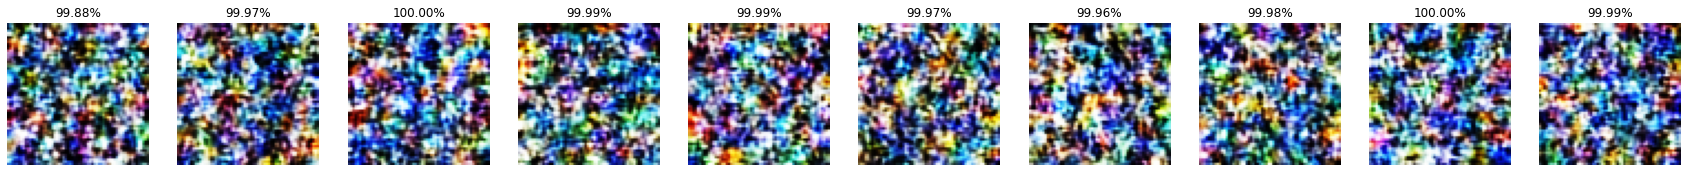

======================== [ Saved BEST ] ========================
====== [Ep 26/100] :   cnnae_loss = 0.00309     classif_loss =     nan =============================================
====== [Ep 27/100] :   cnnae_loss = 0.00306     classif_loss =     nan =============================================
====== [Ep 28/100] :   cnnae_loss = 0.00303     classif_loss =     nan =============================================
====== [Ep 29/100] :   cnnae_loss = 0.00299     classif_loss =     nan =============================================
====== [Ep 30/100] :   cnnae_loss = 0.00299     classif_loss = 0.00052 =============================================


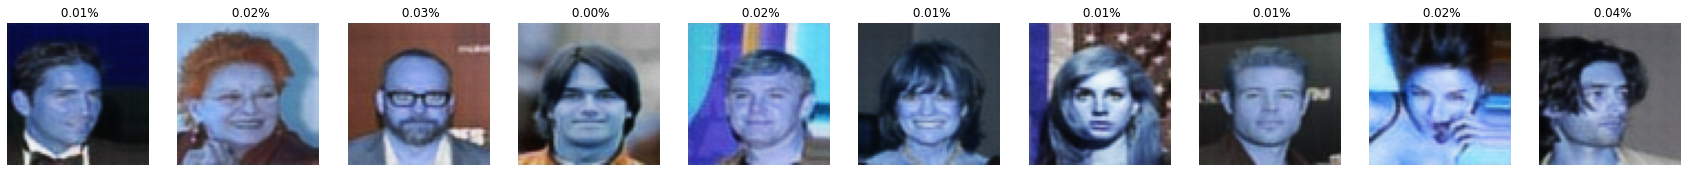

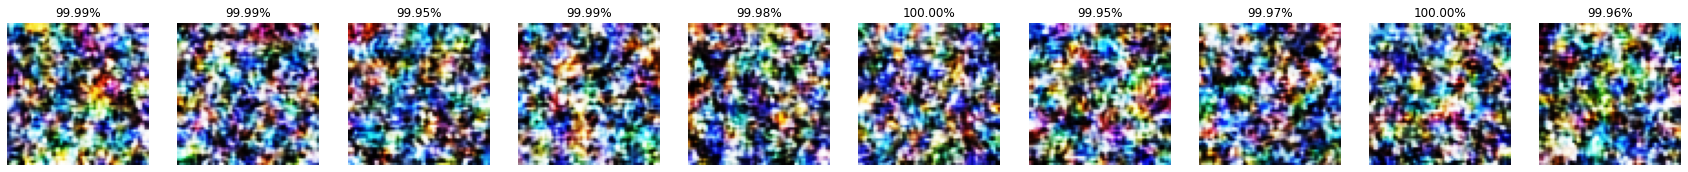

======================== [ Saved BEST ] ========================


KeyboardInterrupt: ignored

In [27]:
torch.autograd.set_detect_anomaly(True)

best_loss, best_classif_loss = np.inf, np.inf
#img_logits = None
model.train()
classifier.train()
classif_interval = 5

for epoch in range(num_epochs):
    tot_loss, tot_classif_loss = list(), list()
    epoch+=1

    for data in train_dataloader:
        img = data.float().cuda()
        img_encd = model(img, mode='encoder')
        img_decd = model(img_encd, mode='decoder')
        #img_decd = model(img_encd.detach(), mode='decoder')

        if epoch % classif_interval == 0:
            # ============================================================
            #  Train Classifier
            # ============================================================
            #img = data.float().cuda()
            #print(classifier(img).shape)

            #img_encd = model(img, mode='encoder')#.detach()  
            img_encd = img_encd.detach()
            norm_distrib = normal.Normal(torch.mean(img_encd), torch.std(img_encd))
            anoml_encd = norm_distrib.sample(img_encd.size()).cuda()

            #detach --> no gradient
            #img_decd = model(img_encd.detach(), mode='decoder')
            anoml_decd = model(anoml_encd.detach(), mode='decoder')

            # classifier outputs logits for imgs
            img_logits = classifier(img_decd.detach())
            anoml_logits = classifier(anoml_decd.detach())

            img_loss = bce_criterion(img_logits, torch.zeros(data.shape[0]).cuda())
            anoml_loss = bce_criterion(anoml_logits, torch.ones(data.shape[0]).cuda())
            classif_loss = img_loss + anoml_loss

            tot_classif_loss.append(classif_loss.item())
            classif_optimizer.zero_grad()
            classif_loss.backward()
            classif_optimizer.step()
        #else:
        #    tot_classif_loss.append(np.inf)

        # ============================================================
        #  Train G (ae)
        # ============================================================
        #output = model(img)
        loss = criterion(img_decd, img)

        tot_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = np.mean(tot_loss)
    mean_classif_loss = np.mean(tot_classif_loss)
    # ===================log========================
    print('====== [Ep{:>3d}/{:>3d}] :   cnnae_loss = {:>7.5f}     classif_loss = {:>7.5f} ============================================='
        .format(epoch, num_epochs, mean_loss, mean_classif_loss))
    if epoch % classif_interval == 0:
        display_img(img_decd.detach(), img_logits)
        display_img(anoml_decd.detach(), anoml_logits)
    # ===================save_best====================
    if mean_loss < best_loss and mean_classif_loss < best_classif_loss and epoch >= classif_interval:
        best_loss = mean_loss
        best_classif_loss = mean_classif_loss
        torch.save(model.state_dict(), 'best_cnnae.pt')           #.format(mean_loss))
        torch.save(classifier.state_dict(), 'best_classif.pt')    #.format(mean_classif_loss))
        print('======================== [ Saved BEST ] ========================')

# ===================save_last========================
torch.save(model.state_dict(), 'last_cnnae.pt')
torch.save(classifier.state_dict(), 'last_classif.pt')


# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [28]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)

In [ ]:
"""
img = next(iter(test_dataloader))
images = [(img[i]+1)/2 for i in range(50)]

grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(30,20))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
"""

In [29]:
# load trained model
#checkpoint_path = 'best_{}_{}.pt'.format(model_type, mean_loss) #f'last_model_{model_type}.pt'
classifier = conv_classifier()
classifier.load_state_dict(torch.load('best_classif.pt'))
classifier.eval().cuda()

#model_classes = {'cnn':conv_autoencoder()}
model = model_classes[model_type]
model.load_state_dict(torch.load('best_cnnae.pt'))
model.eval().cuda()

#model = torch.load(checkpoint_path)
#model.eval()

# prediction file 
out_file = 'PREDICTION_FILE.csv'

In [30]:
eval_loss = nn.MSELoss(reduction='none')

anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader): 

        img = data.float().cuda()

        anoml_prob = classifier(img)

        img_decd = model(img)
        loss = eval_loss(img_decd, img).sum([1, 2, 3])

        """
        if model_type in ['cnn', 'resnet', 'fcn']:
            output = output
        elif model_type in ['res_vae']:
            output = output[0]
        elif model_type in ['vae']: # , 'vqvae'
            output = output[0]

        if model_type in ['fcn']:
            loss = eval_loss(output, img).sum(-1)
        else:
            loss = eval_loss(output, img).sum([1, 2, 3])
        """
        #anomality.append(loss)

        anomality.append(loss*anoml_prob)

anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['Predicted'])
df.to_csv(out_file, index_label = 'Id')



# Training statistics
- Number of parameters
- Training time on colab
- Training curve of the bossbaseline model

- Simple
 - Number of parameters: 3176419
 - Training time on colab: ~ 30 min
- Medium
 - Number of parameters: 47355
 - Training time on colab: ~ 30 min
- Strong
 - Number of parameters: 47595
 - Training time on colab:  4 ~ 5 hrs
- Boss:  
 - Number of parameters: 4364140
 - Training time on colab: 1.5~3 hrs

 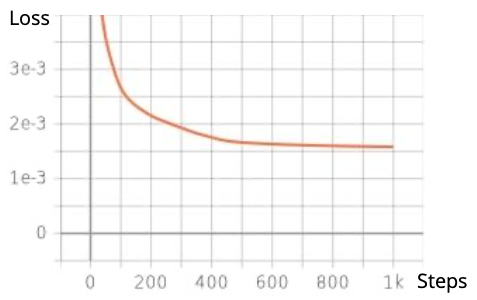
